read dicom

In [1]:
import numpy as np
import skimage.measure
import pydicom
import vtk
from vtk.util import numpy_support
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
plt.gray()
os.chdir('C:/Users/span/Documents/3DSlicerTutorial/CNN.test/')
PathDicom = "./23_5/"

<Figure size 432x288 with 0 Axes>

In [3]:
reader = vtk.vtkDICOMImageReader()
reader.SetDirectoryName(PathDicom)
reader.Update()

# Load dimensions using `GetDataExtent`
_extent = reader.GetDataExtent()
ConstPixelDims = [_extent[1]-_extent[0]+1, _extent[3]-_extent[2]+1, _extent[5]-_extent[4]+1]

# Load spacing values
ConstPixelSpacing = reader.GetPixelSpacing()

# Get the 'vtkImageData' object from the reader
imageData = reader.GetOutput()
# Get the 'vtkPointData' object from the 'vtkImageData' object
pointData = imageData.GetPointData()
# Ensure that only one array exists within the 'vtkPointData' object
assert (pointData.GetNumberOfArrays()==1)
# Get the `vtkArray` (or whatever derived type) which is needed for the `numpy_support.vtk_to_numpy` function
arrayData = pointData.GetArray(0)

# Convert the `vtkArray` to a NumPy array
ArrayDicom = numpy_support.vtk_to_numpy(arrayData)
# Reshape the NumPy array to 3D using 'ConstPixelDims' as a 'shape'
ArrayDicom = ArrayDicom.reshape(ConstPixelDims, order='F')

a = ArrayDicom.copy()

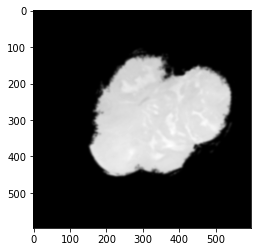

In [7]:
# Adaptive Thresholding
from skimage.filters import threshold_local

a = ArrayDicom.copy()
image = a[:, :, 250].copy()
plt.imshow(image)

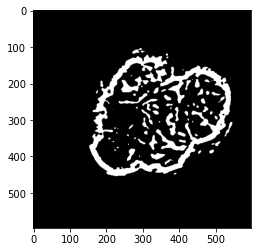

In [5]:
# local threshold 23_5 or 23_8
block_size = 23
binary_image1 = image > (threshold_local(image, block_size,offset=0, method='mean')+20)
plt.imshow(binary_image1)

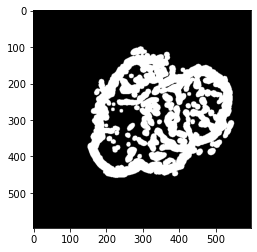

In [6]:
# close gap (blur/extend) 
from skimage import morphology
binary_image2 = morphology.dilation(binary_image1, morphology.disk(radius=5))
plt.imshow(binary_image2)

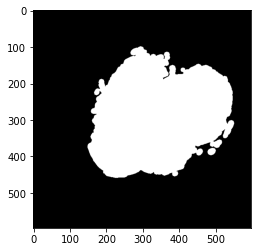

In [8]:
# fill holes
from scipy import ndimage as ndi
fill_coins = ndi.binary_fill_holes(binary_image2)
plt.imshow(fill_coins)

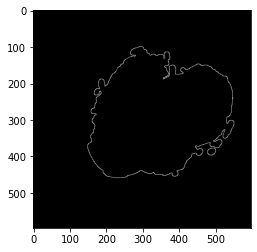

In [22]:
# edge
from skimage.feature import canny
binary_image3 = canny(fill_coins, sigma=1)
plt.imshow(binary_image3)

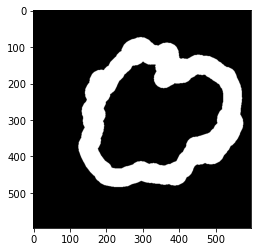

In [23]:
# thicker the edge
from skimage import morphology
binary_image4 = morphology.dilation(binary_image3, morphology.disk(radius=25))
plt.imshow(binary_image4)

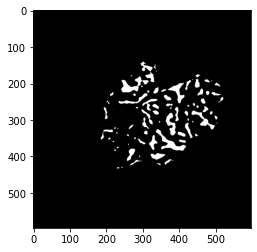

In [24]:
# remove the edge
binary_image5 = binary_image1 > binary_image4
plt.imshow(binary_image5)

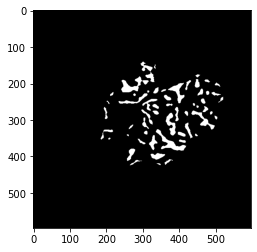

In [25]:
# remove small object
binary_image6 = morphology.remove_small_objects(binary_image5, 21)
plt.imshow(binary_image6)

In [26]:
# for loop
result = np.empty([596, 596])
for i in range(a.shape[2]):
    image = a[:, :, i].copy()
    block_size = 23
    binary_image1 = image > (threshold_local(image, block_size,offset=0, method='mean')+20)
    binary_image2 = morphology.dilation(binary_image1, morphology.disk(radius=5))
    fill_coins = ndi.binary_fill_holes(binary_image2)
    binary_image3 = canny(fill_coins, sigma=1)
    binary_image4 = morphology.dilation(binary_image3, morphology.disk(radius=25))
    binary_image5 = binary_image1 > binary_image4
    binary_image6 = morphology.remove_small_objects(binary_image5, 21)
    result = np.dstack((result, binary_image6))

result.shape

(596, 596, 563)

In [ ]:
# out put vtr
from pyevtk.hl import gridToVTK

x = np.arange(0, result.shape[0]+1)
y = np.arange(0, result.shape[1]+1)
z = np.arange(0, result.shape[2]+1)

gridToVTK("./23_o", x, y, z, cellData = {'result': result})

In [27]:
# write into text and load
# Write the array to disk
with open('23_o_test.txt', 'w') as outfile:
    # I'm writing a header here just for the sake of readability
    # Any line starting with "#" will be ignored by numpy.loadtxt
    outfile.write('# Array shape: {0}\n'.format(result.shape))
    
    # Iterating through a ndimensional array produces slices along
    # the last axis. This is equivalent to data[i,:,:] in this case
    for data_slice in result:

        # The formatting string indicates that I'm writing out
        # the values in left-justified columns 7 characters in width
        # with 2 decimal places.  
        np.savetxt(outfile, data_slice, fmt='%-7.2f')

        # Writing out a break to indicate different slices...
        outfile.write('# New slice\n')

In [ ]:
# Read the array from disk
new_data = np.loadtxt('23_o_test.txt')
# 'C:/Users/span/Documents/3DSlicerTutorial/CNN.test/23_o_test.txt'
# Note that this returned a 2D array!
# print new_data.shape

# However, going back to 3D is easy if we know the 
# original shape of the array
new_data = new_data.reshape((596, 596, 563))
    
# Just to check that they're the same...
assert np.all(new_data == result)